In [15]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

tf.random.set_seed(42)
np.random.seed(42)

igneous_rock_properties = {
    "Schist":      {"velocity": (6.2, 0.1), "amplitude": (0.70, 0.02), "duration": (255, 10), "frequency_Hz": (34, 4)},
    "Gneiss":      {"velocity": (6.4, 0.1), "amplitude": (0.74, 0.02), "duration": (265, 10), "frequency_Hz": (33, 4)},
    "Slate":       {"velocity": (6.3, 0.1), "amplitude": (0.72, 0.02), "duration": (260, 10), "frequency_Hz": (35, 4)},
    "Quartzite":   {"velocity": (6.5, 0.1), "amplitude": (0.75, 0.02), "duration": (270, 10), "frequency_Hz": (32, 4)},
    "Marble":      {"velocity": (6.2, 0.1), "amplitude": (0.71, 0.02), "duration": (250, 10), "frequency_Hz": (34, 4)},
}

def generate_dataset(props, samples_per_class=800, seed=42):
    """Generate dataset with more samples for better training"""
    np.random.seed(seed)
    data = []

    for rock_type, features in props.items():
        for _ in range(samples_per_class):
            row = {
                "rock_type": rock_type,
                "velocity": np.random.normal(*features["velocity"]),
                "amplitude": np.random.normal(*features["amplitude"]),
                "duration": np.random.normal(*features["duration"]),
                "frequency_Hz": np.random.normal(*features["frequency_Hz"])
            }
            data.append(row)

    df = pd.DataFrame(data)
    df = df.sample(frac=1, random_state=seed).reset_index(drop=True)
    return df

df = generate_dataset(igneous_rock_properties)

df['velocity_x_amplitude'] = df['velocity'] * df['amplitude']
df['velocity_squared'] = df['velocity'] ** 2
df['duration_squared'] = df['duration'] ** 2
df['amplitude_duration'] = df['amplitude'] * df['duration']
df['velocity_frequency'] = df['velocity'] * df['frequency_Hz']
df['amplitude_frequency'] = df['amplitude'] * df['frequency_Hz']
df['duration_frequency'] = df['duration'] * df['frequency_Hz']
df['velocity_duration'] = df['velocity'] * df['duration']
df['amplitude_squared'] = df['amplitude'] ** 2
df['frequency_squared'] = df['frequency_Hz'] ** 2
df['velocity_amplitude_ratio'] = df['velocity'] / df['amplitude']
df['duration_frequency_ratio'] = df['duration'] / df['frequency_Hz']
df['velocity_duration_ratio'] = df['velocity'] / df['duration']
df['velocity_cubed'] = df['velocity'] ** 3
df['amplitude_cubed'] = df['amplitude'] ** 3

print(df)

      rock_type  velocity  amplitude    duration  frequency_Hz  \
0        Schist  6.164166   0.687049  262.441920     33.275103   
1        Marble  6.217872   0.706524  259.959549     36.944910   
2        Schist  6.167138   0.712064  249.558860     33.348828   
3        Marble  6.231816   0.718273  240.513781     34.292417   
4     Quartzite  6.638487   0.757933  261.668585     36.263855   
...         ...       ...        ...         ...           ...   
3995     Gneiss  6.351229   0.761487  269.964001     41.300260   
3996     Gneiss  6.269841   0.702940  263.751131     33.062791   
3997     Gneiss  6.414552   0.727718  266.409827     39.354508   
3998     Marble  6.273976   0.739704  261.176324     36.007408   
3999  Quartzite  6.642326   0.747332  256.135106     29.904627   

      velocity_x_amplitude  velocity_squared  duration_squared  \
0                 4.235085         37.996942      68875.761224   
1                 4.393074         38.661926      67578.967263   
2        

In [16]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['rock_type'])
feature_cols = [
    'velocity', 'amplitude', 'duration', 'frequency_Hz',
    'velocity_x_amplitude', 'velocity_squared', 'duration_squared',
    'amplitude_duration', 'velocity_frequency', 'amplitude_frequency',
    'duration_frequency', 'velocity_duration', 'amplitude_squared',
    'frequency_squared', 'velocity_amplitude_ratio', 'duration_frequency_ratio',
    'velocity_duration_ratio', 'velocity_cubed', 'amplitude_cubed'
]

X = df[feature_cols].values
y = df['label'].values

from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [17]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights_dict = dict(enumerate(class_weights))

def create_model(input_dim, num_classes, dropout_rate=0.3):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_dim,)),

        # First block
        tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate),

        # Second block
        tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate),

        # Third block
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate * 0.5),

        # Fourth block
        tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate * 0.5),

        # Output layer
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    return model

model = create_model(X_scaled.shape[1], len(le.classes_))

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [18]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        patience=20,
        restore_best_weights=True,
        monitor='val_accuracy',
        min_delta=0.001
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        factor=0.3,
        patience=8,
        min_lr=1e-6,
        monitor='val_accuracy',
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        "igneous_model_improved.keras",
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1
    )
]

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 512)            │        10,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 186,885 (730.02 KB)

 Trainable params: 184,965 (722.52 KB)

 Non-trainable params: 1,920 (7.50 KB)

In [19]:
print("Training improved model...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=150,  # More epochs with early stopping
    batch_size=64,  # Larger batch size for stability
    callbacks=callbacks,
    class_weight=class_weights_dict,
    verbose=1
)

Training improved model...
Epoch 1/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3945 - loss: 2.2326
Epoch 1: val_accuracy improved from -inf to 0.44875, saving model to igneous_model_improved.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.3954 - loss: 2.2281 - val_accuracy: 0.4487 - val_loss: 1.9532 - learning_rate: 0.0010
Epoch 2/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4783 - loss: 1.8324
Epoch 2: val_accuracy did not improve from 0.44875
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4784 - loss: 1.8316 - val_accuracy: 0.4350 - val_loss: 1.8660 - learning_rate: 0.0010
Epoch 3/150
44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4967 - loss: 1.7496
Epoch 3: val_accuracy did not improve from 0.44875
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4969 - loss: 1.7472 - val_accuracy: 0.4487 - val_loss: 1.8089 - learning_rate: 0.0010
Epoch 4/150
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4990 - loss: 1.7103
Epoch 4: v

In [20]:
model = tf.keras.models.load_model("igneous_model_improved.keras")

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

accuracy = np.mean(y_pred == y_test)
print(f"\nFinal Test Accuracy: {accuracy:.4f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  

Classification Report:
              precision    recall  f1-score   support

      Gneiss       0.49      0.56      0.52       160
      Marble       0.53      0.57      0.55       160
   Quartzite       0.77      0.63      0.69       160
      Schist       0.59      0.51      0.55       160
       Slate       0.46      0.50      0.48       160

    accuracy                           0.56       800
   macro avg       0.57      0.56      0.56       800
weighted avg       0.57      0.56      0.56       800


Final Test Accuracy: 0.5563


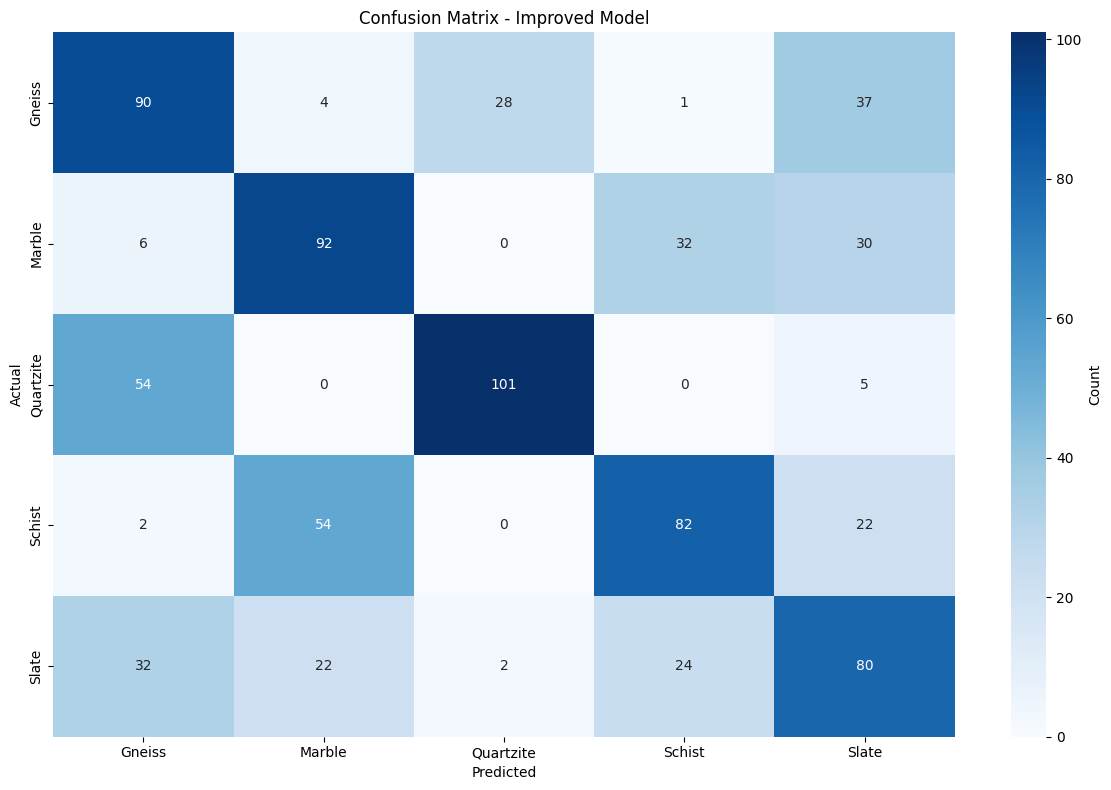

In [21]:
plt.figure(figsize=(12, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_,
            cmap='Blues', cbar_kws={'label': 'Count'})
plt.title("Confusion Matrix - Improved Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

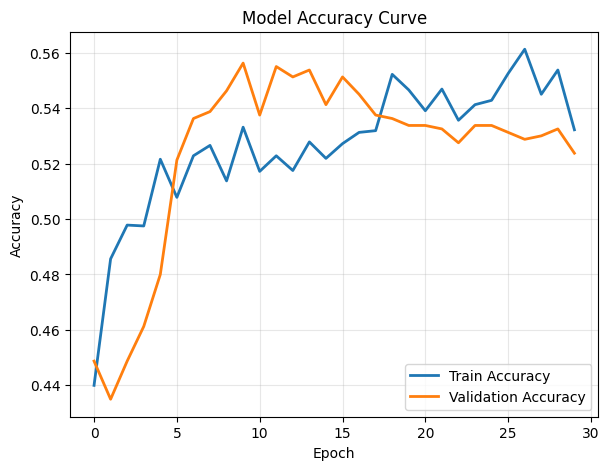

In [22]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title("Model Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)

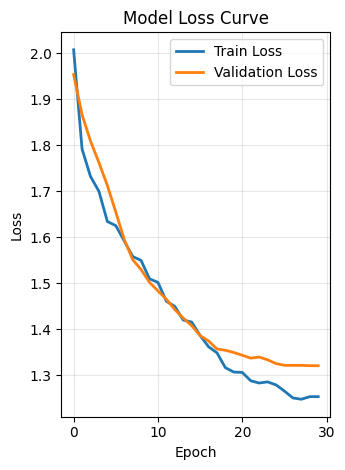

In [23]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title("Model Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Calculating feature importance...


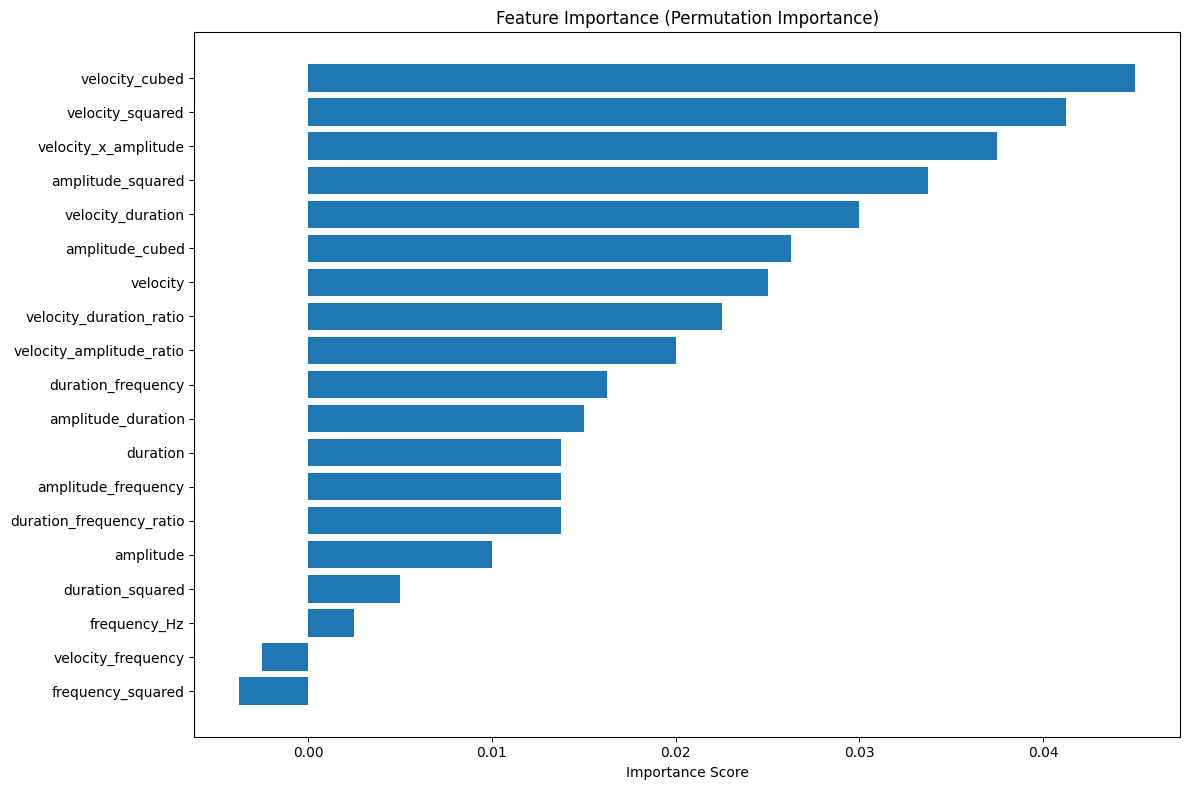

In [24]:
def get_feature_importance(model, X_test, feature_names):
    """Calculate feature importance using permutation importance"""
    baseline_accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
    importance_scores = []
    for i, feature in enumerate(feature_names):
        X_test_permuted = X_test.copy()
        np.random.shuffle(X_test_permuted[:, i])
        permuted_accuracy = model.evaluate(X_test_permuted, y_test, verbose=0)[1]
        importance = baseline_accuracy - permuted_accuracy
        importance_scores.append(importance)
    return importance_scores
print("\nCalculating feature importance...")
importance_scores = get_feature_importance(model, X_test, feature_cols)
plt.figure(figsize=(12, 8))
feature_importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': importance_scores
}).sort_values('importance', ascending=True)

plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.title('Feature Importance (Permutation Importance)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

In [25]:
joblib.dump(scaler, "igneous_scaler.pkl")
joblib.dump(le, "igneous_label_encoder.pkl")
print(f"\nModel saved as: igneous_model.keras")
print(f"Scaler saved as: igneous_scaler.pkl")
print(f"Label encoder saved as: igneous_label_encoder.pkl")
print(f"Final accuracy: {accuracy:.4f}")



Model saved as: igneous_model_improved.keras
Scaler saved as: igneous_scaler_improved.pkl
Label encoder saved as: igneous_label_encoder_improved.pkl
Final accuracy: 0.5563


In [27]:
import numpy as np
from tensorflow.keras.models import load_model
import joblib
model = load_model("igneous_model_improved.keras")
scaler = joblib.load("igneous_scaler_improved.pkl")
le = joblib.load("igneous_label_encoder_improved.pkl")
def engineer_features(velocity, amplitude, duration, frequency_hz):
    features = [velocity, amplitude, duration, frequency_hz]
    velocity_x_amplitude = velocity * amplitude
    velocity_squared = velocity ** 2
    duration_squared = duration ** 2
    amplitude_duration = amplitude * duration
    velocity_frequency = velocity * frequency_hz
    amplitude_frequency = amplitude * frequency_hz
    duration_frequency = duration * frequency_hz
    velocity_duration = velocity * duration
    amplitude_squared = amplitude ** 2
    frequency_squared = frequency_hz ** 2
    velocity_amplitude_ratio = velocity / amplitude
    duration_frequency_ratio = duration / frequency_hz
    velocity_duration_ratio = velocity / duration
    velocity_cubed = velocity ** 3
    amplitude_cubed = amplitude ** 3
    all_features = [
        velocity, amplitude, duration, frequency_hz,
        velocity_x_amplitude, velocity_squared, duration_squared,
        amplitude_duration, velocity_frequency, amplitude_frequency,
        duration_frequency, velocity_duration, amplitude_squared,
        frequency_squared, velocity_amplitude_ratio, duration_frequency_ratio,
        velocity_duration_ratio, velocity_cubed, amplitude_cubed
    ]
    return np.array(all_features).reshape(1, -1)
def predict_rock_type(velocity, amplitude, duration, frequency_hz, verbose=True):
    sample_features = engineer_features(velocity, amplitude, duration, frequency_hz)
    sample_scaled = scaler.transform(sample_features)
    pred_prob = model.predict(sample_scaled, verbose=0)
    pred_index = np.argmax(pred_prob)
    pred_label = le.inverse_transform([pred_index])[0]
    confidence = np.max(pred_prob)
    if verbose:
        print(f"\n🪨 Input Sample:")
        print(f"   Velocity: {velocity} km/s")
        print(f"   Amplitude: {amplitude}")
        print(f"   Duration: {duration} ms")
        print(f"   Frequency: {frequency_hz} Hz")
        print(f"\n📊 Prediction Results:")
        print(f"   Predicted Rock Type: {pred_label}")
        print(f"   Confidence: {confidence:.3f}")
        print(f"\n📈 All Probabilities:")
        for i, rock_type in enumerate(le.classes_):
            print(f"   {rock_type}: {pred_prob[0][i]:.3f}")
    return pred_label, confidence, pred_prob[0]
if __name__ == "__main__":
    velocity = 6.32         # within 6.3 ± 0.1
    amplitude = 0.71        # within 0.72 ± 0.02
    duration = 259          # within 260 ± 10
    frequency_hz = 35.2
    rock_type, confidence, probabilities = predict_rock_type(
        velocity, amplitude, duration, frequency_hz
    )
    print(f"\nFinal Result: {rock_type} (Confidence: {confidence:.3f})")


🪨 Input Sample:
   Velocity: 6.32 km/s
   Amplitude: 0.71
   Duration: 259 ms
   Frequency: 35.2 Hz

📊 Prediction Results:
   Predicted Rock Type: Slate
   Confidence: 0.473

📈 All Probabilities:
   Gneiss: 0.174
   Marble: 0.165
   Quartzite: 0.019
   Schist: 0.169
   Slate: 0.473

Final Result: Slate (Confidence: 0.473)
